Mark Attwood  
28-APR-2024
# Multilayer Perceptron Models with the Kaggle Heart Disease Dataset  

https://www.kaggle.com/datasets/mexwell/heart-disease-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
import copy

import shap

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import F1Score, Recall, AUC

import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def scores(_y_val, _y_pred):
    tn, fp, fn, tp = confusion_matrix(_y_val, _y_pred).ravel()
    specificity = tn / (tn+fp)
    print("Accuracy: ", round(accuracy_score(_y_val, _y_pred), 2)) 
    print("Specificity: ", round(tn / (tn+fp), 2)) 
    print("Recall: ", round(recall_score(_y_val, _y_pred), 2)) 
    print("F1 Score:", round(f1_score(_y_val, _y_pred), 2))

In [3]:
callback_a = ModelCheckpoint(filepath = 'my_best_model.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

In [4]:
def train_model(model, X, y, X_test, y_test, callback=[callback_a, callback_b]):
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall', 'accuracy', 'AUC'])
	return model.fit(X, y, validation_data=(X_test, y_test), epochs=1000, callbacks=callback, verbose=0)

In [5]:
def evaluate_model(model, history, X, y):
    y_pred_k = model.predict(X)
    y_pred_kb = (y_pred_k >= 0.5)*1
    
    scores(y, y_pred_kb)
        
    pd.DataFrame(history.history).iloc[:, [2,4,5,6,7]].plot(figsize=(8,5))
    plt.ylim(-0.05,1.05)
    plt.show()
    
    
    # x = np.arange(0,1.01,.01)
    # recall = [recall_score(y, (y_pred_k >= i)*1) for i in x]
    # accuracy = [accuracy_score(y, (y_pred_k >= i)*1) for i in x]
    # sns.scatterplot(x=x, y=recall, label="recall", s=20)
    # sns.scatterplot(x=x, y=accuracy, label="accuracy", s=20)
    # plt.title("Recall and Accuracy Againt Probability Cut-Off")
    # plt.ylabel("Recall or Accuracy")
    # plt.xlabel("Cut-Off Value")
    # plt.legend()
    # plt.show()
    
    
    conf_matrix = confusion_matrix(y_true=y, y_pred=y_pred_kb)
    vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    vis.plot()
    plt.show()

In [6]:
def one_hot_encode(data, col_name, drop_first=True):
    values = sorted(list(data.unique()))
    df_oh = pd.DataFrame()
    for value in values:
        df_oh[col_name+"_"+str(value)] = np.where(data == value, 1, 0)
    if drop_first:
        return df_oh.iloc[:, 1:]
    else:
        return df_oh

## Phase 1: Data Analysis and Preparation  

* Once you have found a dataset you like
* load the data in a Python Notebook
* normalize your data. CANNOT DO THIS UNTIL DATA IS SPLIT.
* In your report’s introduction section please discuss:
    - why you chose to work on this project
    - explain the problem you plan to solve.
    - mention the source of your dataset.

        
* visualize/plot the distributions of each input feature and discuss the range of the values (min, max, mean, median, etc.). For example, plot histograms showing distribution of each input features. Selected visualizations should be included in the report.

* Discuss the distribution of the output labels.
* Check if the data is imbalanced by calculating what percentage of the output labels are 0 and what percentage are 1. If your dataset is heavily imbalanced (for example, 1% vs 99%) it may be a better idea to choose a different dataset. 

In [7]:
df = pd.read_csv("heart.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [9]:
df.head(3)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
sex,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.00,1.0
chest pain type,1190.0,3.232773,0.935480,1.0,3.0,4.0,4.00,4.0
resting bp s,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0
cholesterol,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
fasting blood sugar,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.00,1.0
resting ecg,1190.0,0.698319,0.870359,0.0,0.0,0.0,2.00,2.0
max heart rate,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
exercise angina,1190.0,0.387395,0.487360,0.0,0.0,0.0,1.00,1.0
oldpeak,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2


In [11]:
df.target.value_counts(normalize=True).round(2)

target
1    0.53
0    0.47
Name: proportion, dtype: float64

In [12]:
cat_cols = ["chest pain type", "resting ecg", "ST slope"]
cat_prefs = ["chest_pain_type", "ecg", "ST_slope"]
numeric_cols = ["age", "resting_bp_s", "cholesterol", "max_heart_rate", "oldpeak"]

In [13]:
for col, name in zip(cat_cols, cat_prefs):
    df_temp = one_hot_encode(df[col], name)
    df.drop(labels=col, axis=1, inplace=True)
    df = pd.concat([df, df_temp], axis=1)

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
sex,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.00,1.0
resting bp s,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0
cholesterol,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
fasting blood sugar,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.00,1.0
max heart rate,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
exercise angina,1190.0,0.387395,0.487360,0.0,0.0,0.0,1.00,1.0
oldpeak,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2
target,1190.0,0.528571,0.499393,0.0,0.0,1.0,1.00,1.0
chest_pain_type_2,1190.0,0.181513,0.385604,0.0,0.0,0.0,0.00,1.0


In [15]:
# Remove white space from feature names
for col in df.columns:
    df.rename({col: col.replace(" ", "_")}, axis=1, inplace=True)

In [16]:
cat_cols_d = ['sex', 'fasting_blood_sugar',
       'exercise_angina', 'target',
       'chest_pain_type_2', 'chest_pain_type_3', 'chest_pain_type_4', 'ecg_1',
       'ecg_2', 'ST_slope_1', 'ST_slope_2', 'ST_slope_3']

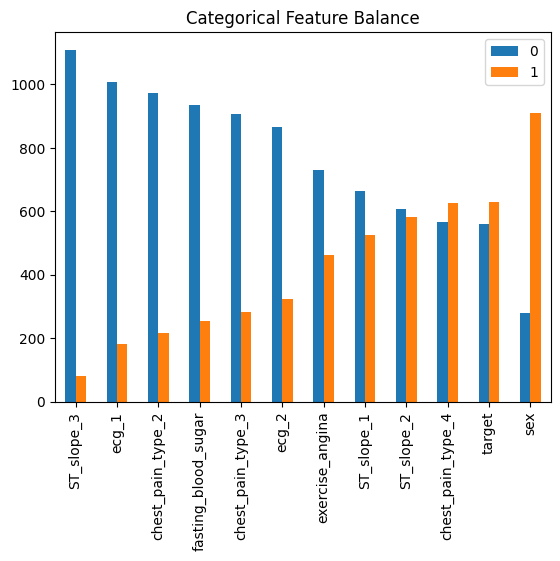

In [17]:
df.loc[:,cat_cols_d].apply(pd.Series.value_counts).transpose().dropna().astype(int).sort_values(by=1.0).plot(kind='bar')
plt.title("Categorical Feature Balance")
plt.show()

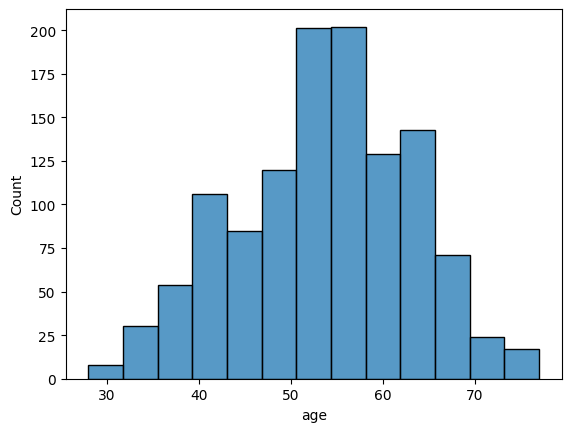

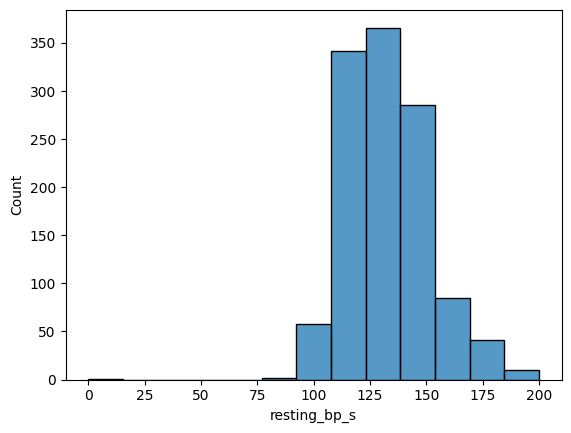

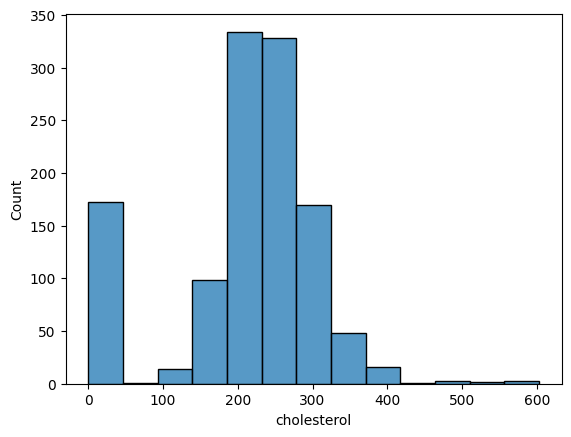

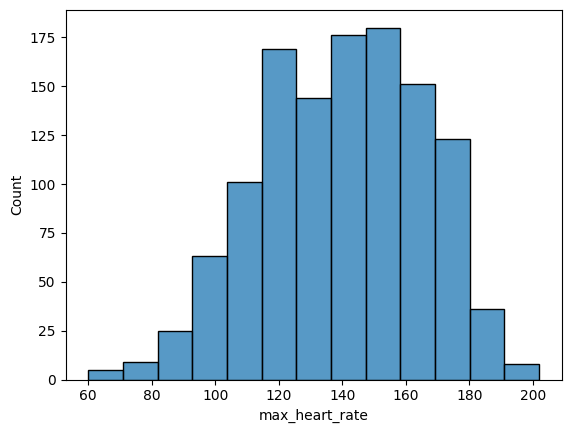

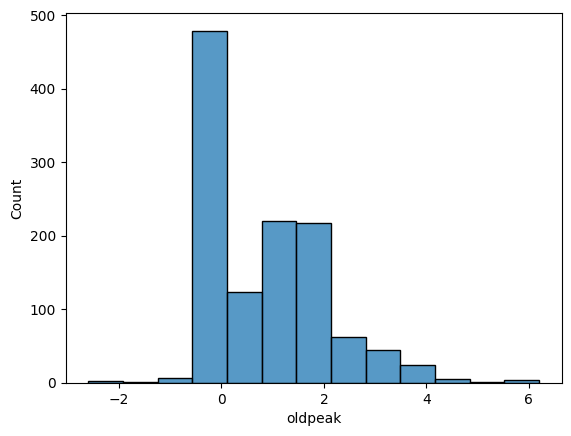

In [18]:
for column in numeric_cols:
    sns.histplot(data = df, x=column, bins=13)
    plt.show()

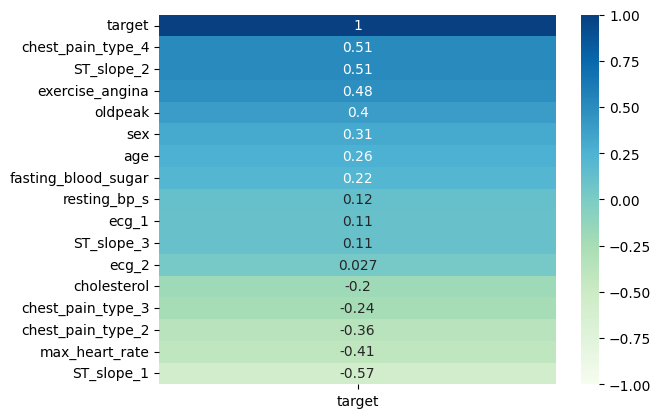

In [19]:
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.heatmap(df.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='GnBu')
plt.show()

## Phase 2: Build a Model to Overfit the Entire Dataset

The main goal in this phase is to experiment and find what network size is needed to ‘overfit’ the entire dataset at your hand.  

* Do not split your data into training and validation.  

* The place to start is to use ‘logistic regression’ model and train for as many epochs as needed to obtain as high accuracy as possible. 
After training hundreds of epochs if you observe that the accuracy is not increasing then it implies that the number of neurons in your model (only one) may not be sufficient for overfitting.  

* The next step is to grow your model into a multi-layer model and add a few neurons (say only 2) in the input layer. This way your model will have ‘2 + 1 = 3’ neurons in total.
* If your accuracy still does not each a 100% or close to 100% you can continue to increase the number of layers and number of neurons.
* Once you have obtained 100% accuracy (or around 100%) your experiments for this phase are complete.

The results of this experiment also inform us that our final model (in subsequent phases) should be smaller than this model. 

### Standardize Numeric Data and Prepare for Use in ML Models

In [20]:
def data_norms(data):
    mean_ = data.mean()
    std_ = data.std()
    return (data - mean_)/std_

In [21]:
np.random.seed(2112)
df_2 = df.copy().sample(frac=1)

In [22]:
for column in numeric_cols:
    df_2[column] = data_norms(df_2[column])

In [23]:
df_2[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1190.0,-3.015328e-16,1.0,-2.748409,-0.718105,0.029902,0.671051,2.487639
resting_bp_s,1190.0,3.119820e-16,1.0,-7.194461,-0.661653,-0.117252,0.427149,3.693553
cholesterol,1190.0,9.852063e-17,1.0,-2.074175,-0.220506,0.183751,0.585544,3.871369
max_heart_rate,1190.0,-4.522993e-16,1.0,-3.124614,-0.734111,0.030067,0.794244,2.440164
oldpeak,1190.0,1.000134e-16,1.0,-3.242799,-0.849435,-0.297121,0.623404,4.857817


In [24]:
X = df_2.drop(axis=1, labels='target')
y = df_2['target']

### Build increasingly more complex models

In [25]:
model = Sequential()
model.add(Dense(1, input_dim=X.shape[1], activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 17 (68.00 Byte)
Trainable params: 17 (68.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 316us/step
Accuracy:  0.85
Specificity:  0.83
Recall:  0.88
F1 Score: 0.86


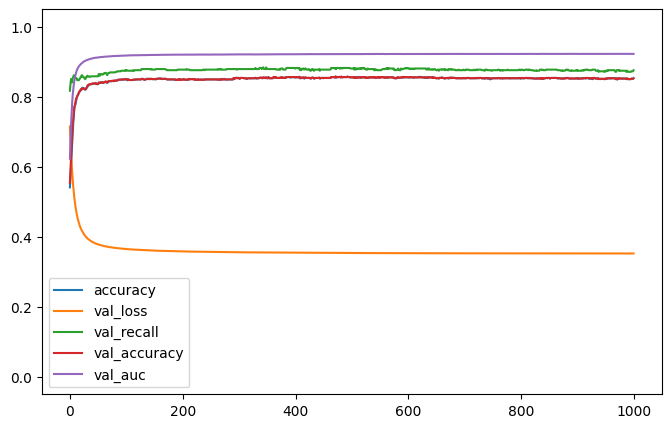

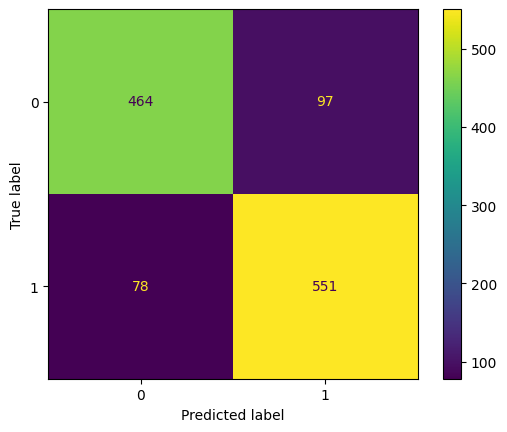

In [26]:
evaluate_model(model, history, X, y)

In [27]:
model = Sequential()
model.add(Dense(2, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 368us/step
Accuracy:  0.86
Specificity:  0.85
Recall:  0.88
F1 Score: 0.87


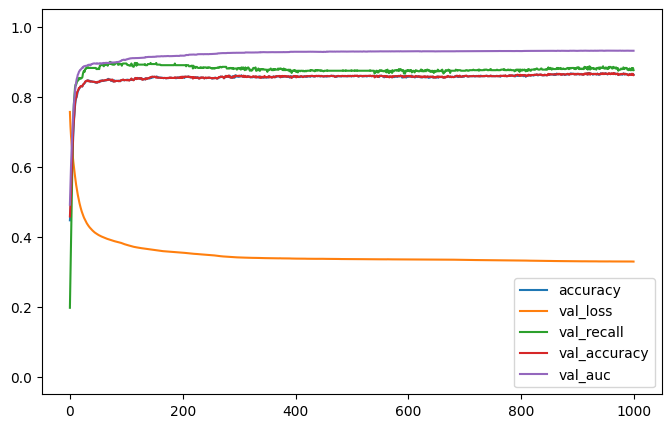

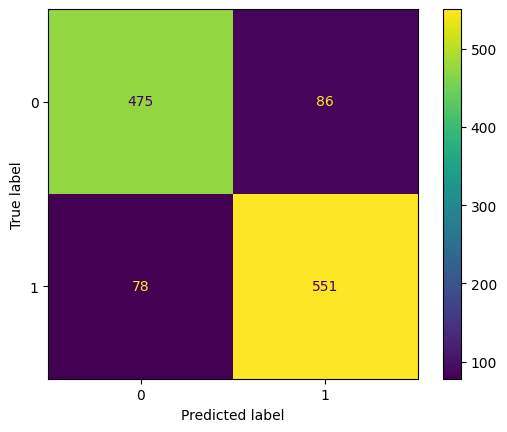

In [28]:
evaluate_model(model, history, X, y)

In [29]:
model = Sequential()
model.add(Dense(4, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73 (292.00 Byte)
Trainable params: 73 (292.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 363us/step
Accuracy:  0.88
Specificity:  0.86
Recall:  0.9
F1 Score: 0.89


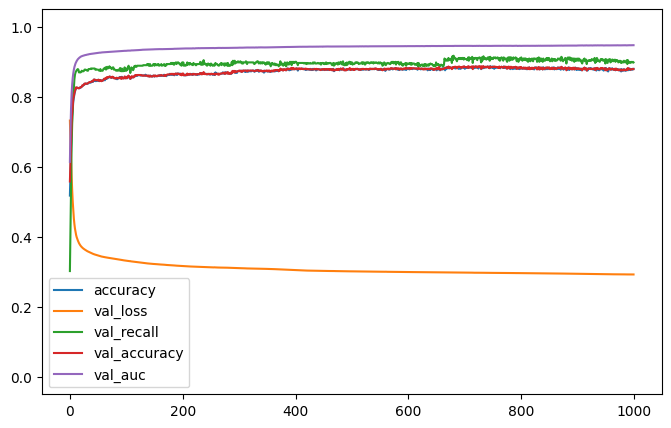

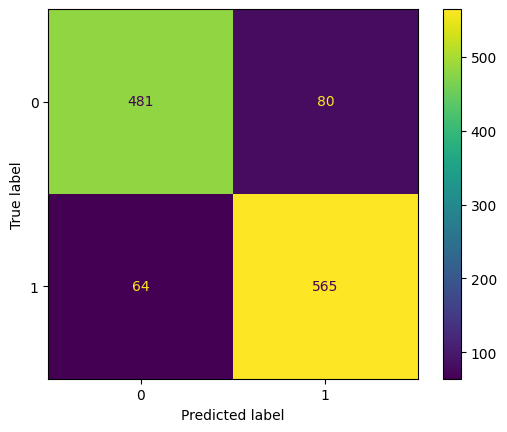

In [30]:
evaluate_model(model, history, X, y)

In [31]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 398us/step
Accuracy:  0.91
Specificity:  0.89
Recall:  0.93
F1 Score: 0.91


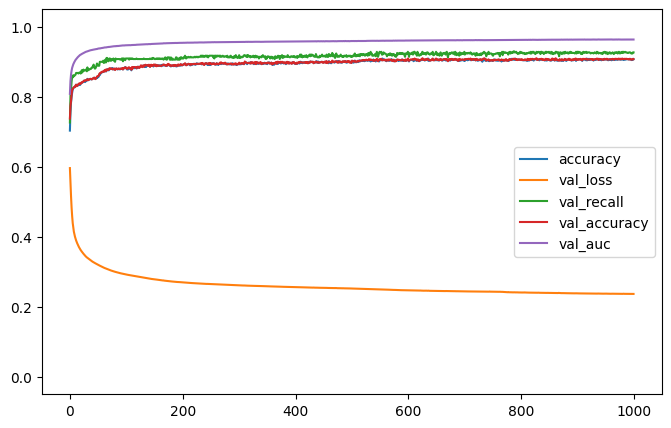

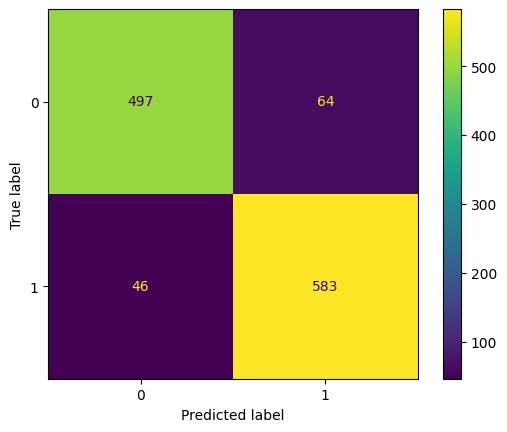

In [32]:
evaluate_model(model, history, X, y)

In [33]:
model = Sequential()
model.add(Dense(12, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 12)                204       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 217 (868.00 Byte)
Trainable params: 217 (868.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 371us/step
Accuracy:  0.94
Specificity:  0.93
Recall:  0.96
F1 Score: 0.95


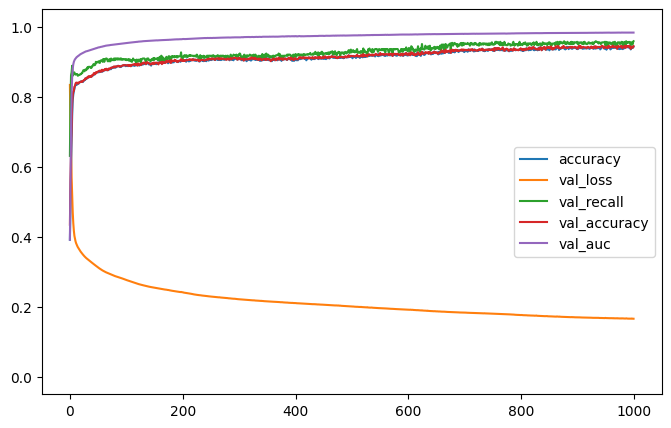

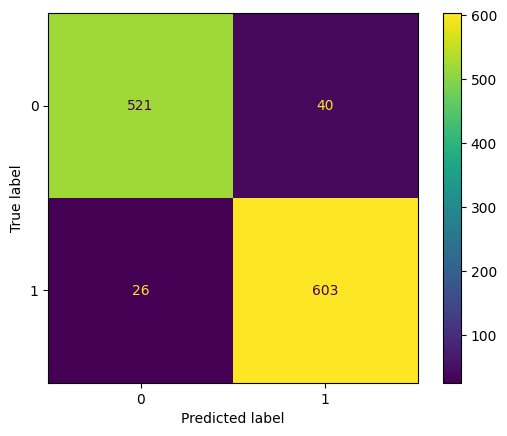

In [34]:
evaluate_model(model, history, X, y)

In [35]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 289 (1.13 KB)
Trainable params: 289 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 371us/step
Accuracy:  0.97
Specificity:  0.97
Recall:  0.98
F1 Score: 0.97


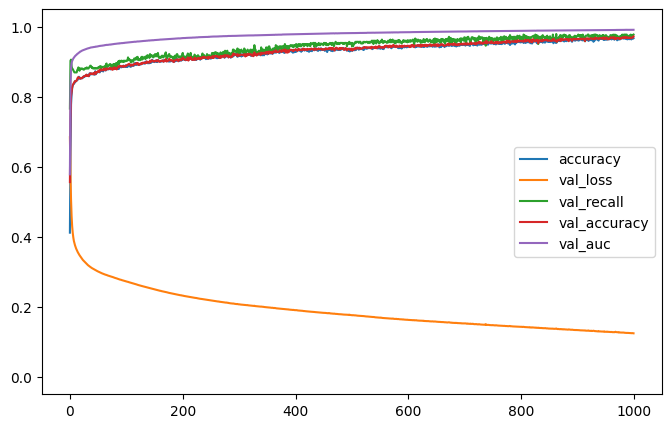

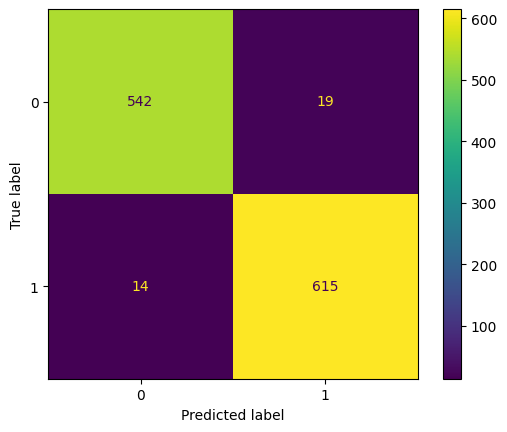

In [36]:
evaluate_model(model, history, X, y)

In [37]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 2)                 34        
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 309 (1.21 KB)
Trainable params: 309 (1.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 398us/step
Accuracy:  0.98
Specificity:  0.97
Recall:  0.99
F1 Score: 0.98


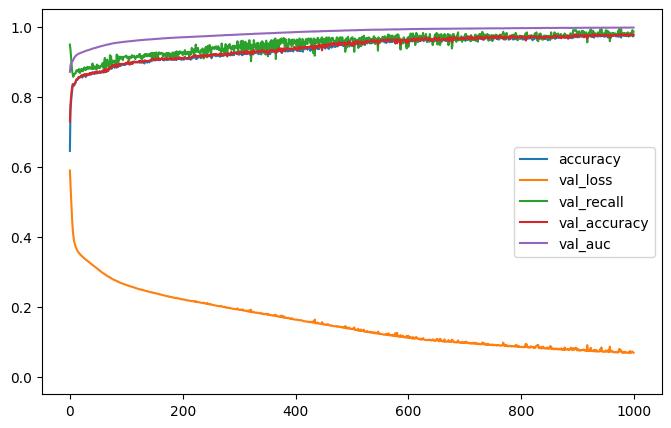

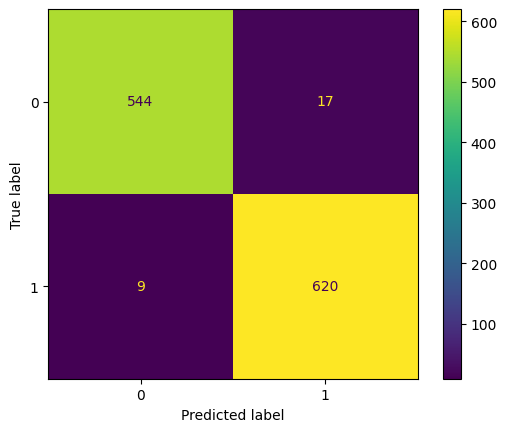

In [38]:
evaluate_model(model, history, X, y)

In [39]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 4)                 68        
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 345 (1.35 KB)
Trainable params: 345 (1.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 378us/step
Accuracy:  1.0
Specificity:  0.99
Recall:  1.0
F1 Score: 1.0


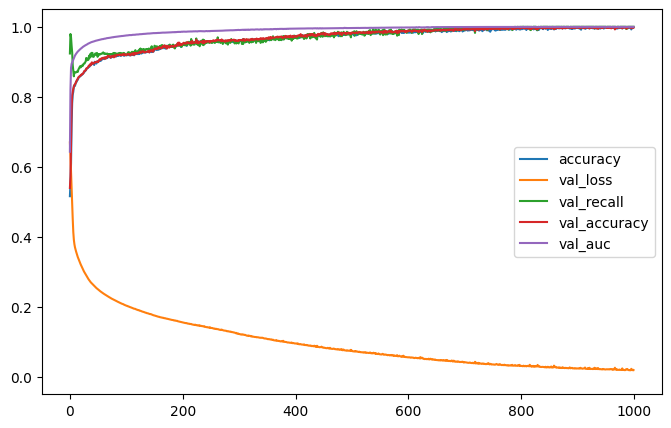

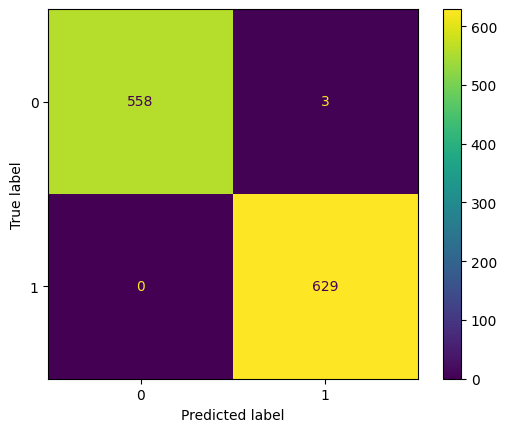

In [40]:
evaluate_model(model, history, X, y)

In [41]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 417 (1.63 KB)
Trainable params: 417 (1.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 372us/step
Accuracy:  1.0
Specificity:  1.0
Recall:  1.0
F1 Score: 1.0


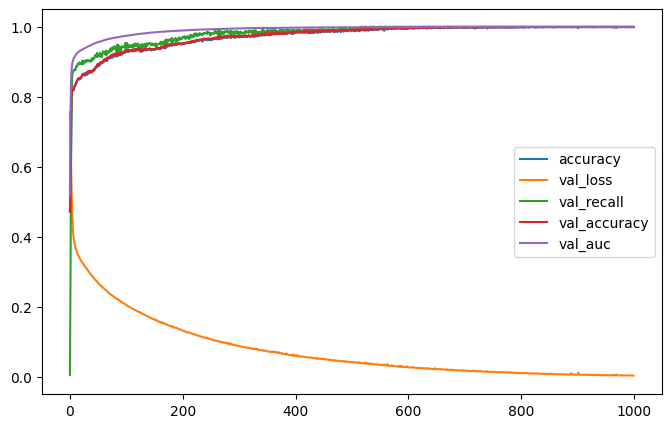

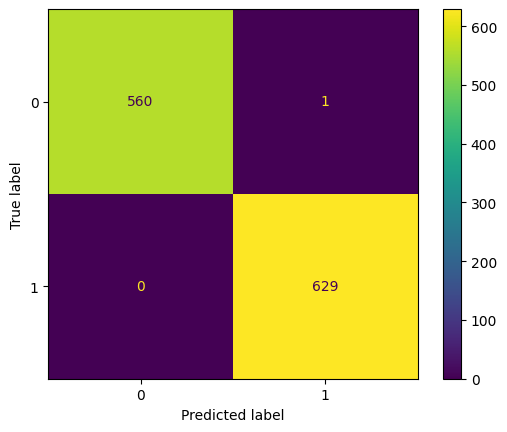

In [42]:
evaluate_model(model, history, X, y)

In [43]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 561 (2.19 KB)
Trainable params: 561 (2.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


38/38 [==============================] - 0s 410us/step
Accuracy:  1.0
Specificity:  1.0
Recall:  1.0
F1 Score: 1.0


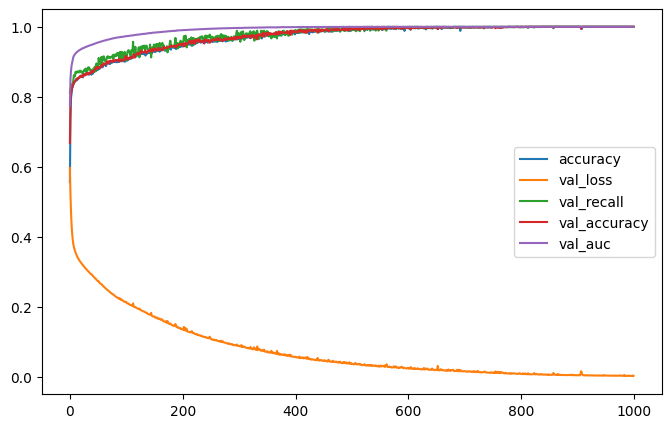

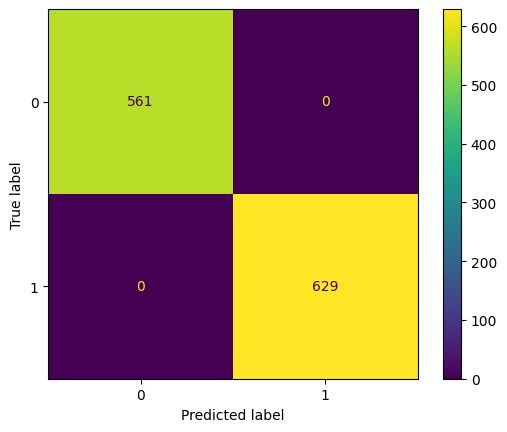

In [44]:
evaluate_model(model, history, X, y)

In [45]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X, y, X, y)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 16)                272       
                                                                 
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 16)                272       
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 833 (3.25 KB)
Trainable params: 833 (3.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 710: early stopping


38/38 [==============================] - 0s 403us/step
Accuracy:  1.0
Specificity:  1.0
Recall:  1.0
F1 Score: 1.0


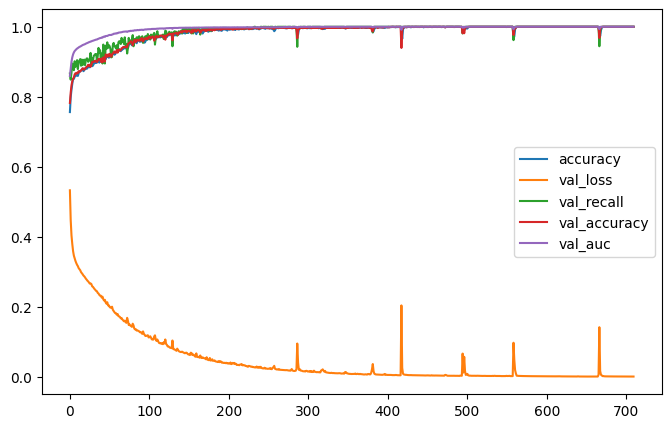

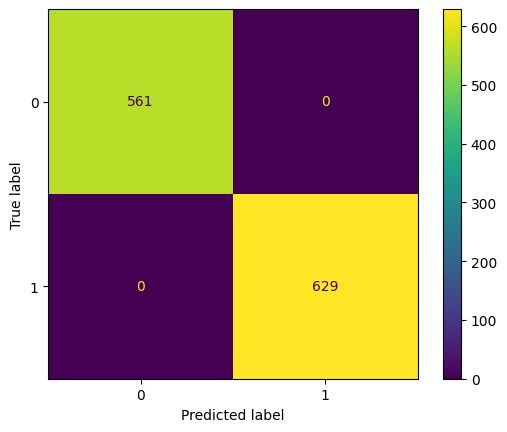

In [46]:
evaluate_model(model, history, X, y)

## Phase 3: Model Selection and Evaluation


The main goal in this phase is to obtain highest possible accuracy on the validation set after splitting your data into training set and validation set.  
* Please shuffle your rows before splitting.
* As your baseline model, i.e., the model with minimum accuracy, you can test the accuracy on the validation set using a ‘logistic regression’ model.
* Gradually grow your model into a multi-layered model and investigate if larger models deliver higher accuracy on the validation set.
    * As you explore various network architectures, please note the accuracies of these models to include in your report.
    * You can summarize your findings in the form of a table and the table should contain the accuracy and loss on the training set and the validation set (see below).
    * You can also include other parameters such as number of epochs, number of neurons, total number of parameters, etc.
 * Remember to select one model as your best performing model, i.e., the model that delivers highest accuracy on the validation set.
 * Your report should also include learning curves of your experiments.
 * You should also evaluate your models using other metrics besides precision; for example recall, precision, and F1 score.
 * Please note that your submission for this phase is ineligible for points if you do not use “model checkpointing” in your code.
 * You are discouraged to use external library methods such as “from sklearn.model_selection import train_test_split”.



[FOR GRADUATE STUDENTS ONLY] 

* discuss what architecture (how big) you do need to overfit when you have output as additional input feature,
* code a function that represents your model.
    * Once you have finished coding your model, please build your own function/method that serves as a prediction model.
    * Afterwards, please verify that predictions you obtain are same as the one you obtained using your trained model.

In [47]:
# shuffle rows
np.random.seed(2112)
df = df.sample(frac=1)

In [48]:
df.shape

(1190, 17)

In [49]:
# split our data
df_train = df.iloc[:990, :]
df_test = df.iloc[990:, :]

In [50]:
X_train = df_train.drop(axis=1, labels='target')
y_train = df_train['target']
X_test = df_test.drop(axis=1, labels='target')
y_test = df_test['target']

In [51]:
# Create a transformer from the training data and use it to res-scale the training and test data

In [52]:
transform_dict = {}

for column in numeric_cols:
    transform_dict[column] = X_train[column].mean(), X_train[column].std()

In [53]:
transform_dict

{'age': (53.58585858585859, 9.37048924959344),
 'resting_bp_s': (132.07676767676767, 18.642888615007955),
 'cholesterol': (209.33030303030304, 101.84296180130552),
 'max_heart_rate': (139.65454545454546, 25.558629333612505),
 'oldpeak': (0.9293939393939393, 1.0990641466017517)}

In [54]:
def data_norms_2(data, mean, std):  
    return (data - mean)/std

In [55]:
for column in numeric_cols:
    X_train[column] = data_norms_2(X_train[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1])

In [56]:
for column in numeric_cols:
    X_test[column] = data_norms_2(X_test[column], 
                                            transform_dict[column][0], 
                                            transform_dict[column][1])

In [57]:
# Verify
X_train[numeric_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,990.0,-2.727336e-16,1.0,-2.730472,-0.702830,0.044196,0.684504,2.498711
resting_bp_s,990.0,1.830186e-16,1.0,-7.084566,-0.647795,-0.111397,0.425000,3.643386
cholesterol,990.0,-1.094523e-16,1.0,-2.055422,-0.209443,0.198047,0.585899,3.865458
max_heart_rate,990.0,-6.728624e-17,1.0,-3.116542,-0.729873,0.013516,0.796031,2.439311
oldpeak,990.0,1.040694e-16,1.0,-3.211272,-0.845623,-0.299704,0.587414,4.795540


### Logistic Regression

In [58]:
formula = "target ~"
for col in X_train.columns:
    formula += " + "
    formula += col
logit = smf.logit(formula, data=pd.concat([X_train, y_train], axis=1)).fit()

         Current function value: 0.337665
         Iterations: 35


/Users/markattwood/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  990
Model:                          Logit   Df Residuals:                      973
Method:                           MLE   Df Model:                           16
Date:                Sun, 28 Apr 2024   Pseudo R-squ.:                  0.5117
Time:                        18:23:10   Log-Likelihood:                -334.29
converged:                      False   LL-Null:                       -684.63
Covariance Type:            nonrobust   LLR p-value:                9.243e-139
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              25.7491   1.65e+06   1.56e-05      1.000   -3.23e+06    3.23e+06
age                     0.2414      0.116      2.076      0.038       0.014       0.469
sex             

In [60]:
# Note the coefficients on the ST_slope variables. There is likely an issue of over-identification.
# We will drop the variable with the lowest correlation to our target, "ST_slope_3", and see what happens.
formula = "target ~"
for col in X_train.drop(labels=["ST_slope_3"], axis=1).columns:
    formula += " + "
    formula += col
logit = smf.logit(formula, data=pd.concat([X_train.drop(labels=["ST_slope_3"], axis=1), y_train], axis=1)).fit()

Optimization terminated successfully.
         Current function value: 0.338564
         Iterations 7


In [61]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  990
Model:                          Logit   Df Residuals:                      974
Method:                           MLE   Df Model:                           15
Date:                Sun, 28 Apr 2024   Pseudo R-squ.:                  0.5104
Time:                        18:23:11   Log-Likelihood:                -335.18
converged:                       True   LL-Null:                       -684.63
Covariance Type:            nonrobust   LLR p-value:                3.182e-139
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.2516      0.597     -5.448      0.000      -4.421      -2.082
age                     0.2520      0.116      2.173      0.030       0.025       0.479
sex             

In [62]:
# Drop the extra feature 
X.drop(labels=["ST_slope_3"], axis=1, inplace=True)
X_train.drop(labels=["ST_slope_3"], axis=1, inplace=True)
X_test.drop(labels=["ST_slope_3"], axis=1, inplace=True)

Accuracy:  0.81
Specificity:  0.78
Recall:  0.85
F1 Score: 0.83


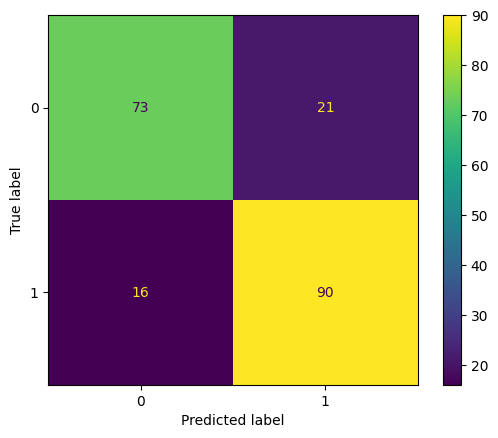

In [63]:
y_pred_logit = logit.predict(X_test)
y_pred_logit = (y_pred_logit >= 0.5)*1
scores(y_test, y_pred_logit)
conf_matrix = confusion_matrix(y_test, y_pred=y_pred_logit)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
vis.plot()
plt.show()

### MLPs

In [64]:
model = Sequential()
model.add(Dense(2, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 2)                 32        
                                                                 
 dense_28 (Dense)            (None, 1)                 3         
                                                                 
Total params: 35 (140.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 110: early stopping


7/7 [==============================] - 0s 659us/step
Accuracy:  0.82
Specificity:  0.79
Recall:  0.86
F1 Score: 0.84


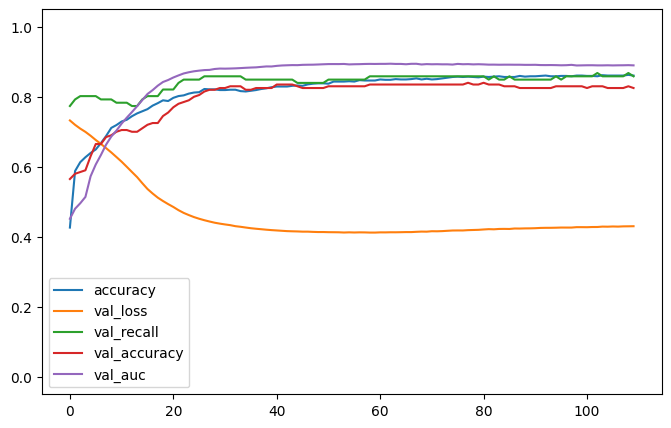

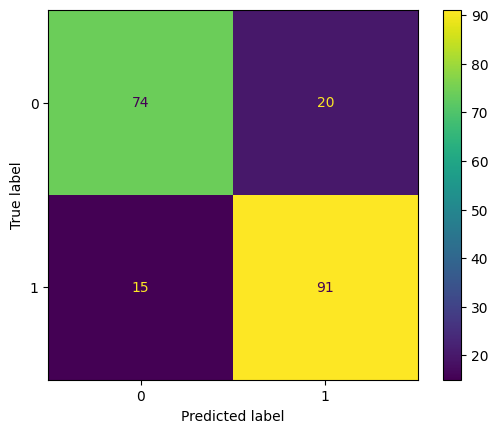

In [65]:
evaluate_model(model, history, X_test, y_test)

In [66]:
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 8)                 128       
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 137 (548.00 Byte)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 85: early stopping


7/7 [==============================] - 0s 547us/step
Accuracy:  0.84
Specificity:  0.81
Recall:  0.88
F1 Score: 0.86


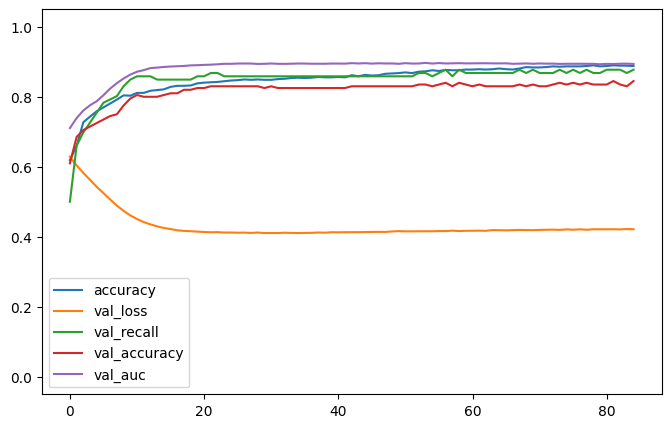

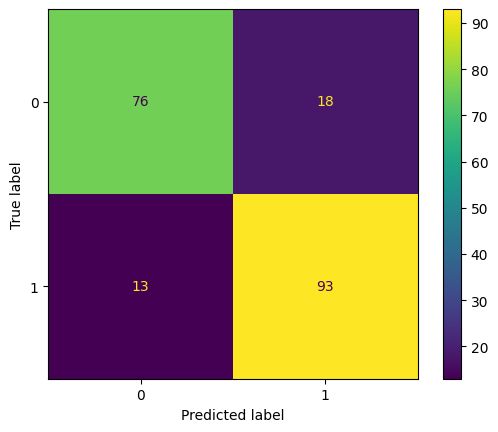

In [67]:
evaluate_model(model, history, X_test, y_test)

In [68]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 16)                256       
                                                                 
 dense_32 (Dense)            (None, 4)                 68        
                                                                 
 dense_33 (Dense)            (None, 1)                 5         
                                                                 
Total params: 329 (1.29 KB)
Trainable params: 329 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 166: early stopping


7/7 [==============================] - 0s 482us/step
Accuracy:  0.86
Specificity:  0.87
Recall:  0.85
F1 Score: 0.87


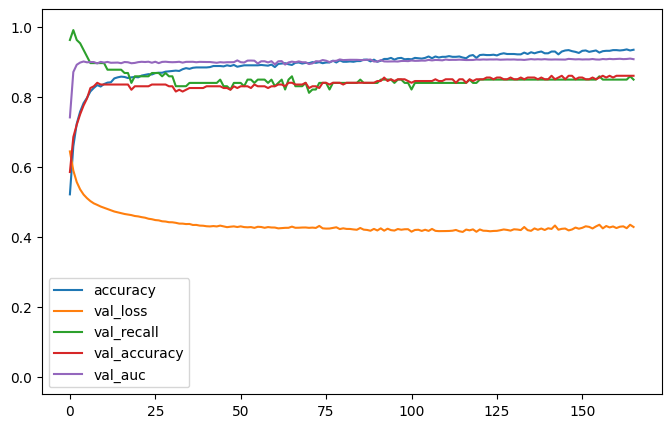

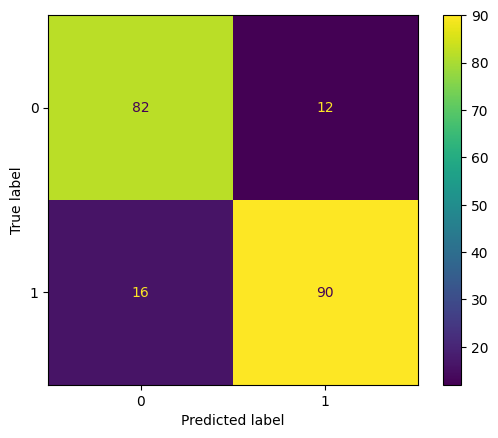

In [69]:
evaluate_model(model, history, X_test, y_test)

In [70]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 16)                256       
                                                                 
 dense_35 (Dense)            (None, 16)                272       
                                                                 
 dense_36 (Dense)            (None, 1)                 17        
                                                                 
Total params: 545 (2.13 KB)
Trainable params: 545 (2.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 72: early stopping


7/7 [==============================] - 0s 521us/step
Accuracy:  0.83
Specificity:  0.81
Recall:  0.85
F1 Score: 0.84


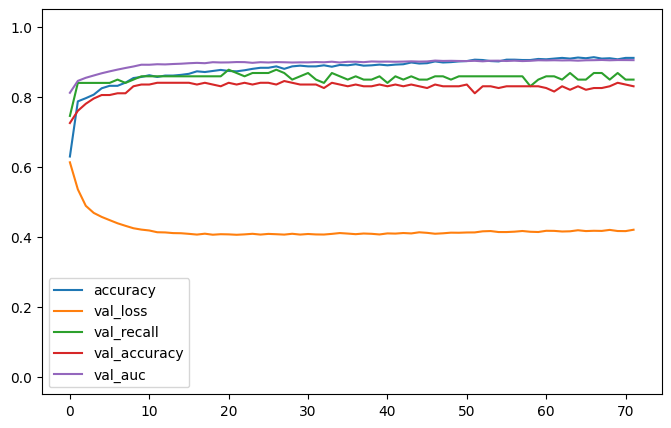

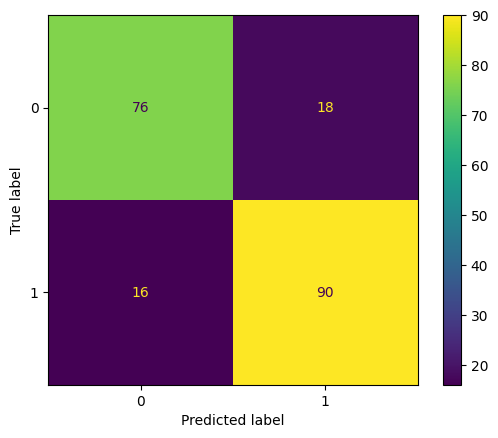

In [71]:
evaluate_model(model, history, X_test, y_test)

In [72]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                256       
                                                                 
 dense_38 (Dense)            (None, 16)                272       
                                                                 
 dense_39 (Dense)            (None, 8)                 136       
                                                                 
 dense_40 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673 (2.63 KB)
Trainable params: 673 (2.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 101: early stopping


7/7 [==============================] - 0s 530us/step
Accuracy:  0.82
Specificity:  0.79
Recall:  0.86
F1 Score: 0.84


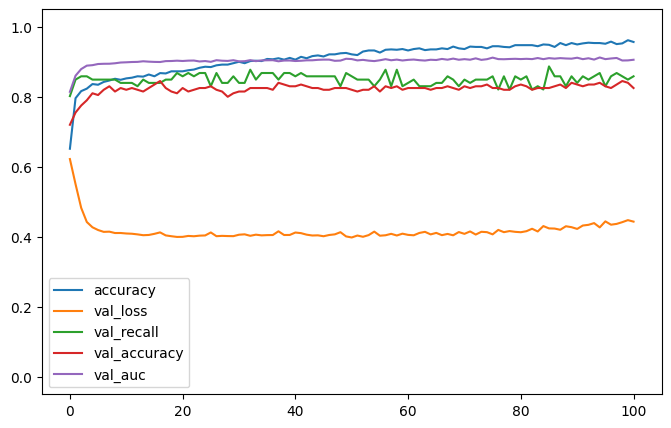

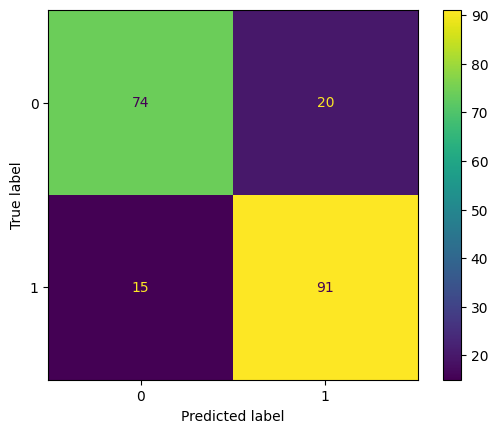

In [73]:
evaluate_model(model, history, X_test, y_test)

In [74]:
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
history = train_model(model, X_train, y_train, X_test, y_test)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 79: early stopping


7/7 [==============================] - 0s 552us/step
Accuracy:  0.88
Specificity:  0.85
Recall:  0.91
F1 Score: 0.89


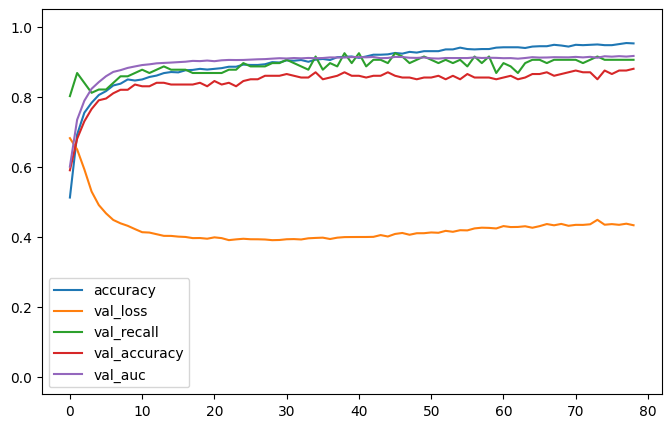

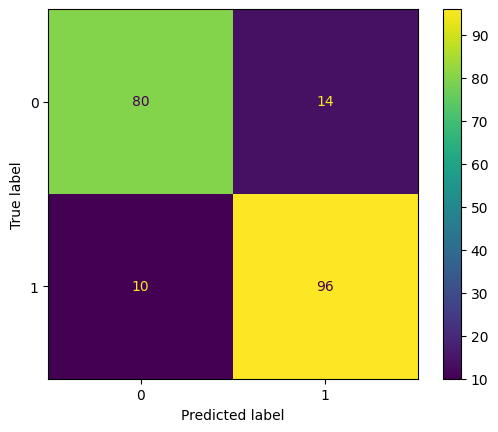

In [75]:
evaluate_model(model, history, X_test, y_test)

In [76]:
model_f = Sequential()
model_f.add(Dense(16, input_dim=X.shape[1], activation='relu'))
model_f.add(Dense(16, activation='relu'))
model_f.add(Dense(12, activation='relu'))
model_f.add(Dense(12, activation='relu'))
model_f.add(Dense(1, activation='sigmoid'))
print(model.summary())
history_f = train_model(model_f, X_train, y_train, X_test, y_test)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 78: early stopping


7/7 [==============================] - 0s 557us/step
Accuracy:  0.88
Specificity:  0.85
Recall:  0.91
F1 Score: 0.89


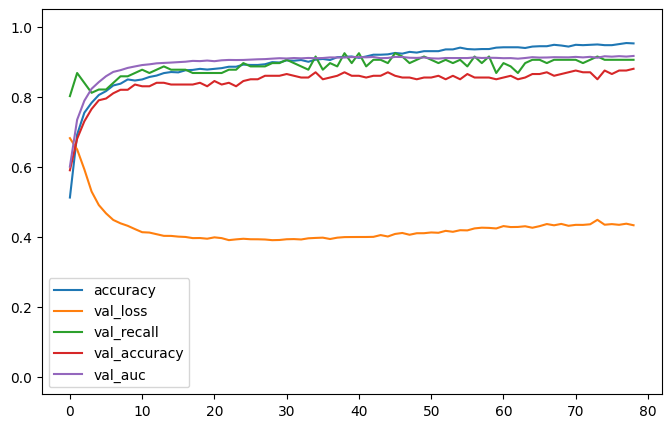

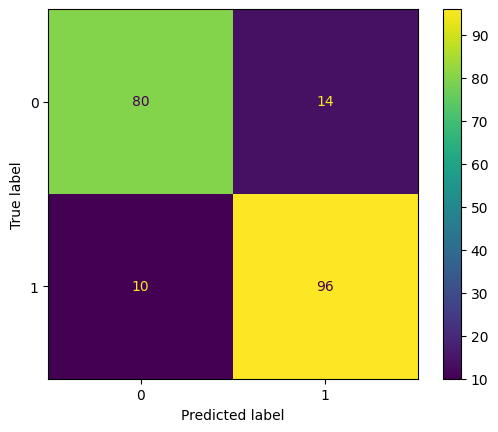

In [77]:
evaluate_model(model, history, X_test, y_test)

### What architecture (how big) you do need to overfit when you have output as additional input feature? 

Below we use the output from our best model and iteratively train a model with the previous model's output. The below architecture is the "slimmest" we could find that would perfectly classify the training set.

In [78]:
train_pred = model_f.predict(X_train)
test_pred = model_f.predict(X_test)

7/7 [==============================] - 0s 553us/step


In [79]:
X_train_grad =X_train.copy()
X_train_grad["preds"] = train_pred

X_test_grad = X_test.copy()
X_test_grad["preds"] = test_pred

accs = []
Epoch = 1
Go = True


while Go:  
    model_g = Sequential()
    model_g.add(Dense(9, input_dim = X_train_grad.shape[1], activation='relu'))
    model_g.add(Dense(1, activation='sigmoid'))
    history = train_model(model_g, X_train_grad, y_train, X_train_grad, y_train)
    X_train_grad["preds"] = model_g.predict(X_train_grad)
    X_test_grad["preds"] = model_g.predict(X_test_grad)
    
    _acc = accuracy_score(y_train, (X_train_grad["preds"]>0.5)*1)
    accs.append(_acc)
    print(f"Epoch {Epoch}: {_acc: 0.4f}")   
    if _acc > 0.999:
        Go = False
    Epoch += 1

7/7 [==============================] - 0s 635us/step
Epoch 1:  0.9828
7/7 [==============================] - 0s 497us/step
Epoch 2:  0.9929
7/7 [==============================] - 0s 491us/step
Epoch 3:  0.9990
7/7 [==============================] - 0s 479us/step
Epoch 4:  1.0000


7/7 [==============================] - 0s 503us/step
Accuracy:  0.85
Specificity:  0.83
Recall:  0.87
F1 Score: 0.86


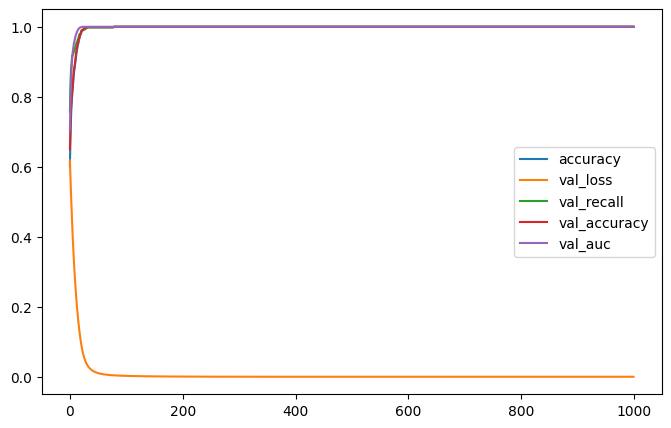

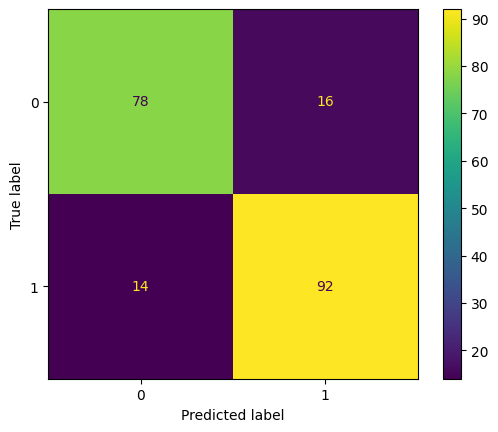

In [80]:
evaluate_model(model_g, history, X_test_grad, y_test)

Below is the minimum architecture needed using output as input in order to achieve 100% in-sample accuracy.

In [81]:
print(model_g.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 9)                 153       
                                                                 
 dense_57 (Dense)            (None, 1)                 10        
                                                                 
Total params: 163 (652.00 Byte)
Trainable params: 163 (652.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Phase 4: Feature Importance and Reduction  
The key activity in this phase is to study the importance of the input features by iteratively removing them. You must continue to use model checkpointing in this phase. Here are the steps involved:

* If you have 10 input features/columns, train 10 models where each model only receives one feature at a time.
    * For example, if age, BMI, and blood pressure are your only three input features, you train three models: one that only take age as input, another that only takes BMI as the input, and the last one that takes only blood pressure as the input.
    * The validation accuracy of these three models will indicate the relative importance of the three features.
    * You should plot these validation accuracies in the form of a bar diagram. If all your accuracies are more than 80%, your plot’s y-axis should be limited to 80-100.
* From the previous step you have the significance/important of each feature. The feature that yields the highest accuray is the most important feature.
    * Starting with the most unimportant feature, remove one feature at a time (without replacement) and train various models.
    * You can iteratively repeat the process removing more and more unimportant features. For example, if BMI is the most important feature and blood pressure is the least important one, you would train two models: one without blood pressure, and one without blood pressure and age.
    * Plot the validation dataset accuracy of all the models that you tested. The overall objective is to identify non-informative input features and remove them from the dataset.
* Finally, you can compare your feature-reduced model with the original model with all input features and discuss the difference in accuracy. 

For bonus points: Use model-agnostic methods such as LIME or Shapley values to derive feature importance. 
 
 https://christophm.github.io/interpretable-ml-book/

In [82]:
def create_model():
    model = Sequential()
    model.add(Dense(1, input_dim=1, activation='sigmoid'))
    return model

In [83]:
feature_models = []
for i in range(X_train.shape[1]):
    feature_models.append((create_model(), X_train.iloc[:, i], y_train,  X_test.iloc[:, i], y_test))

In [84]:
from funcs import mp_train

In [85]:
pool = multiprocessing.Pool()
history = pool.starmap(mp_train, feature_models)
pool.close()
pool.join()

In [86]:
def f_acc(idx, model_list, _X, _y):
    _preds = model_list[idx][0].predict(_X.iloc[:,idx])
    _y_preds_01 = (_preds >= 0.5)*1
    return accuracy_score(_y_preds_01, _y)

In [87]:
feature_scores = {}
cols = X_train.columns
for i in range(X_train.shape[1]):
    feature_scores[cols[i]] = f_acc(i, feature_models, X_test, y_test)

7/7 [==============================] - 0s 639us/step


In [88]:
feature_scores = dict(sorted(feature_scores.items(), key=lambda item: item[1]))

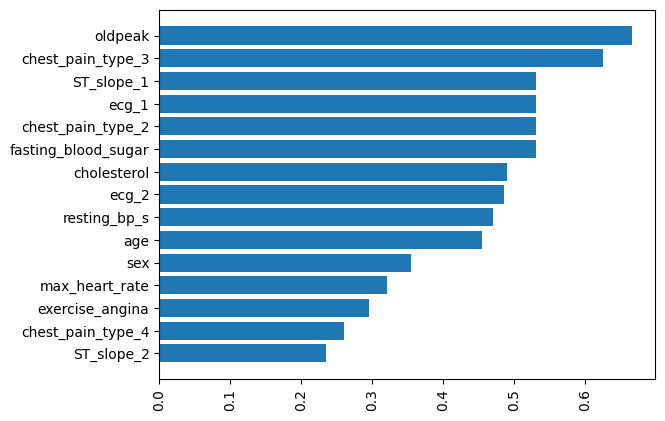

In [89]:
plt.barh(*zip(*feature_scores.items()))
plt.xticks(rotation=90)
plt.show()

In [90]:
feature_scores

{'ST_slope_2': 0.235,
 'chest_pain_type_4': 0.26,
 'exercise_angina': 0.295,
 'max_heart_rate': 0.32,
 'sex': 0.355,
 'age': 0.455,
 'resting_bp_s': 0.47,
 'ecg_2': 0.485,
 'cholesterol': 0.49,
 'fasting_blood_sugar': 0.53,
 'chest_pain_type_2': 0.53,
 'ecg_1': 0.53,
 'ST_slope_1': 0.53,
 'chest_pain_type_3': 0.625,
 'oldpeak': 0.665}

In [91]:
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# Fits the explainer
np.random.seed(2112)
explainer = shap.Explainer(model_f.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test, silent=True)

43/43 [==============================] - 0s 344us/step


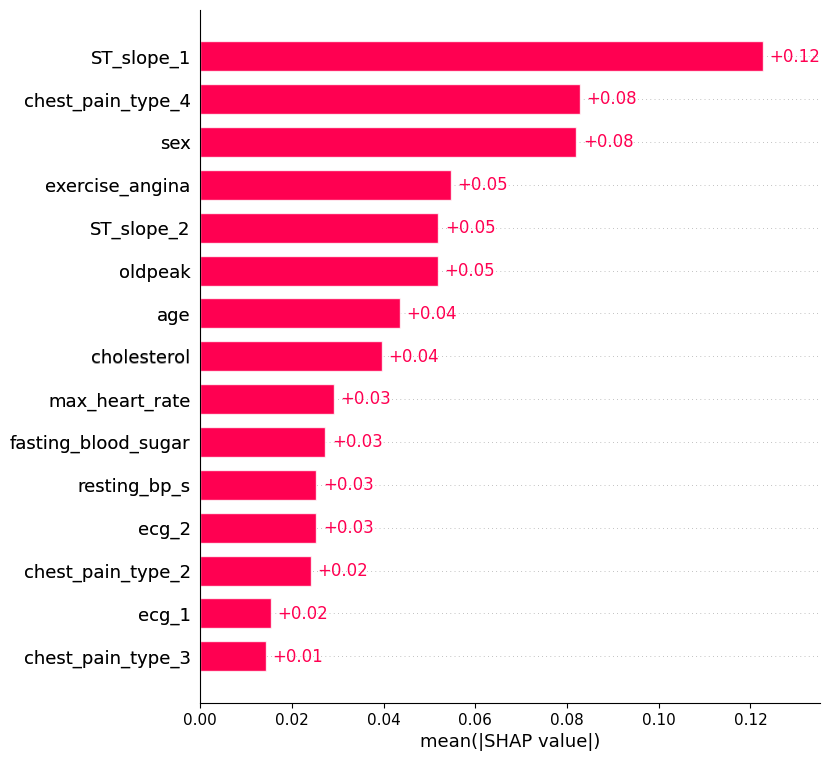

In [92]:
shap.plots.bar(shap_values, max_display=1000)

Epoch 98: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['resting_bp_s', 'ecg_2', 'fasting_blood_sugar', 'age', 'max_heart_rate', 'chest_pain_type_2', 'cholestero

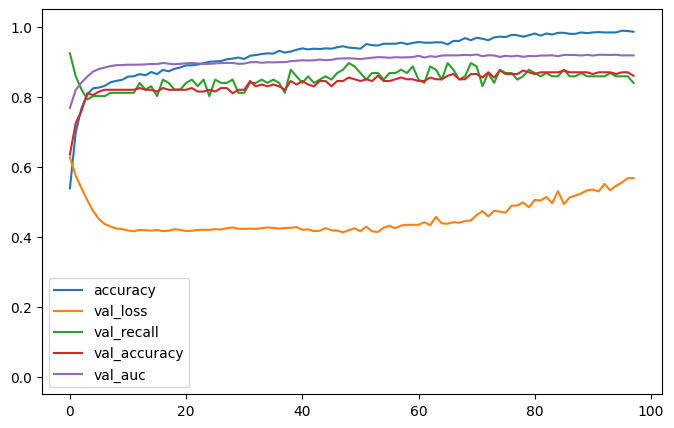

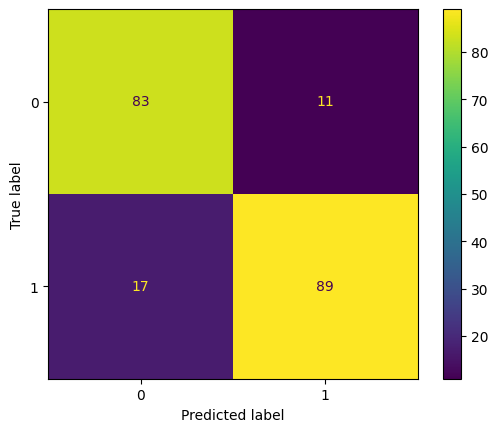

Epoch 62: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['ecg_2', 'fasting_blood_sugar', 'age', 'max_heart_rate', 'chest_pain_type_2', 'cholesterol', 'exercise_an

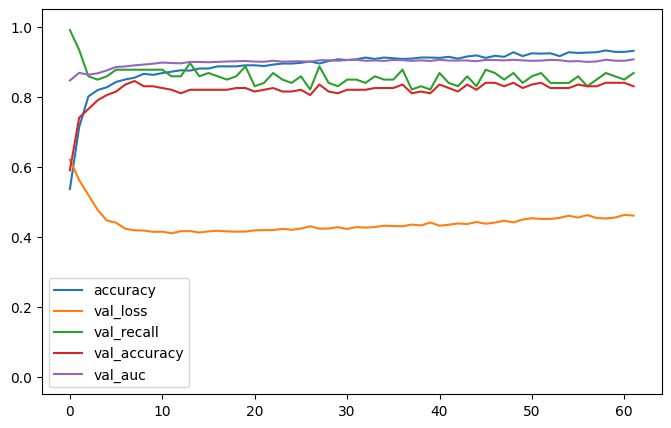

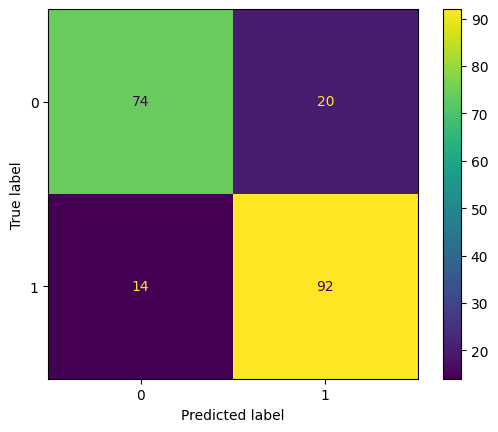

Epoch 62: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['fasting_blood_sugar', 'age', 'max_heart_rate', 'chest_pain_type_2', 'cholesterol', 'exercise_angina', 'c

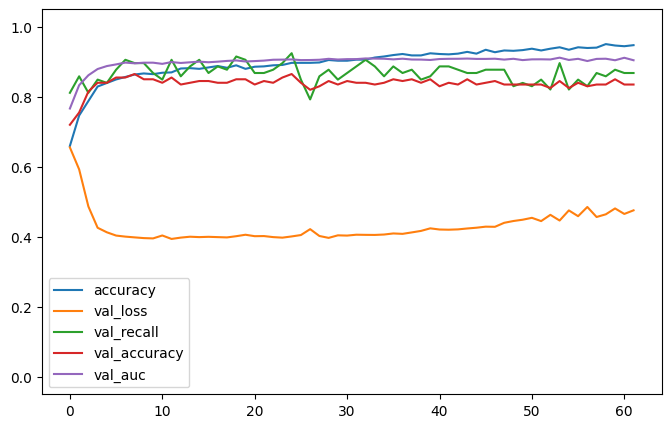

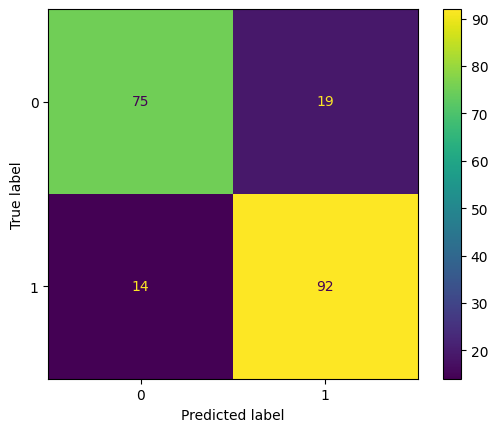

Epoch 120: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['age', 'max_heart_rate', 'chest_pain_type_2', 'cholesterol', 'exercise_angina', 'chest_pain_type_3', 'ol

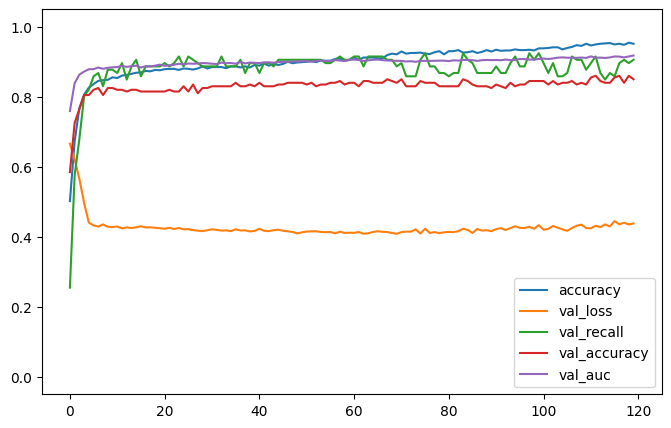

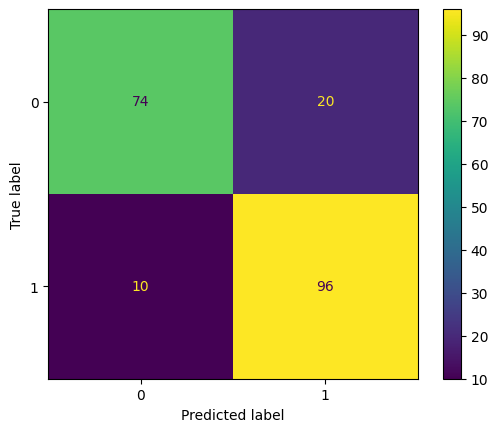

Epoch 83: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['max_heart_rate', 'chest_pain_type_2', 'cholesterol', 'exercise_angina', 'chest_pain_type_3', 'oldpeak', 

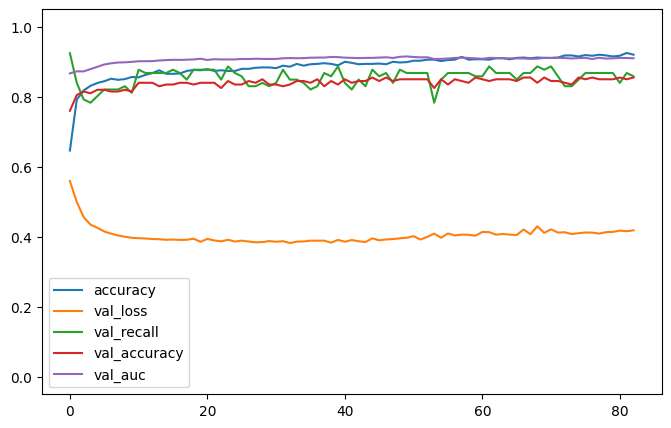

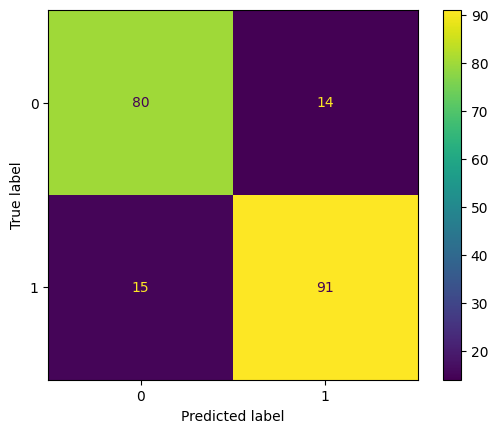

Epoch 92: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['chest_pain_type_2', 'cholesterol', 'exercise_angina', 'chest_pain_type_3', 'oldpeak', 'chest_pain_type_4

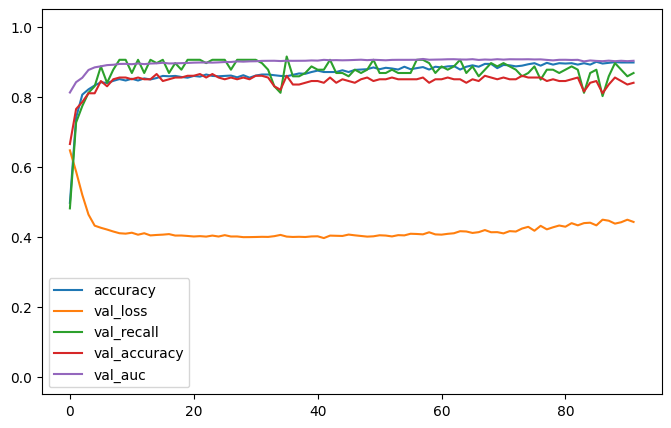

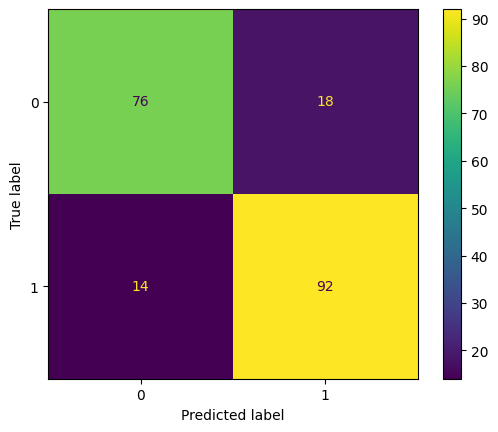

Epoch 138: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['cholesterol', 'exercise_angina', 'chest_pain_type_3', 'oldpeak', 'chest_pain_type_4', 'ST_slope_1', 'ST

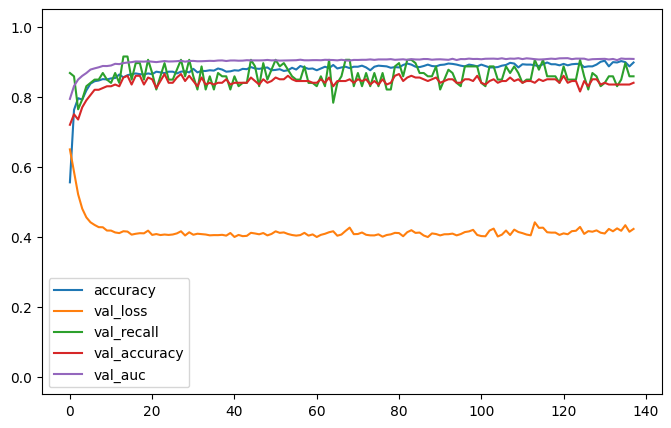

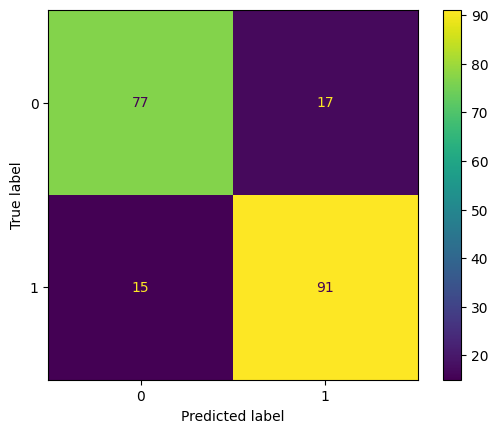

Epoch 67: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['exercise_angina', 'chest_pain_type_3', 'oldpeak', 'chest_pain_type_4', 'ST_slope_1', 'ST_slope_2', 'sex'

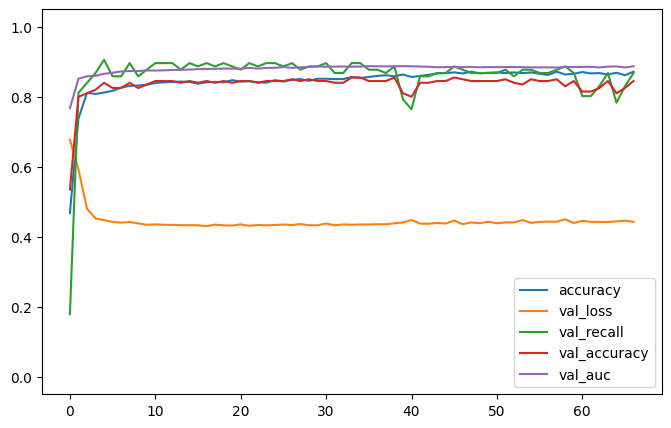

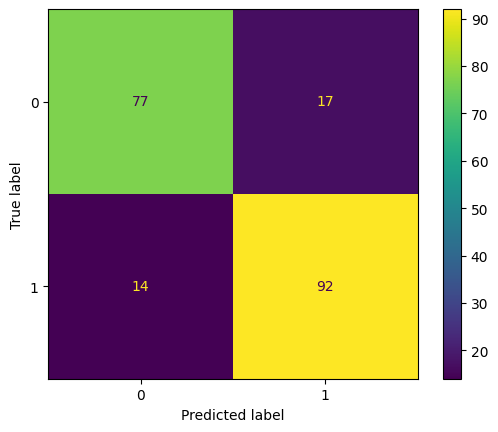

Epoch 64: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['chest_pain_type_3', 'oldpeak', 'chest_pain_type_4', 'ST_slope_1', 'ST_slope_2', 'sex']
7/7 [============

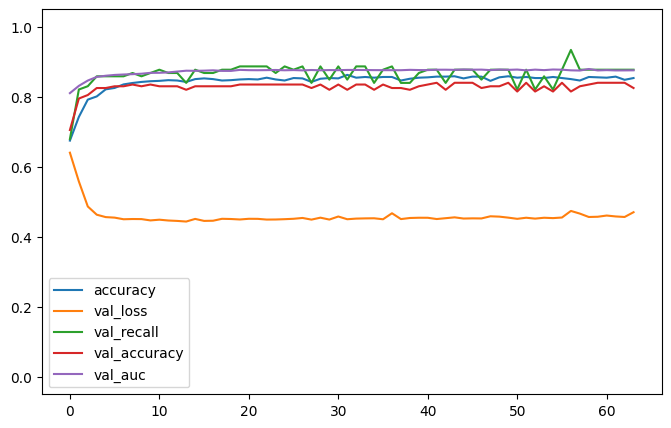

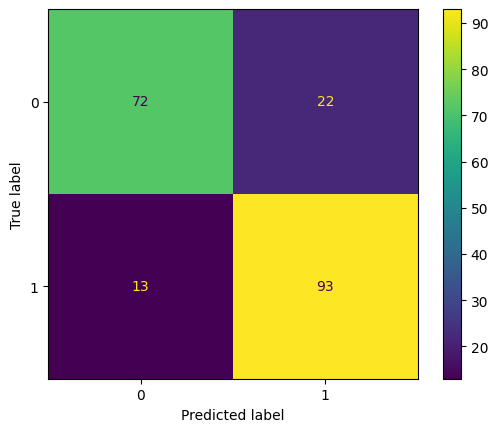

Epoch 84: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['oldpeak', 'chest_pain_type_4', 'ST_slope_1', 'ST_slope_2', 'sex']
7/7 [==============================] -

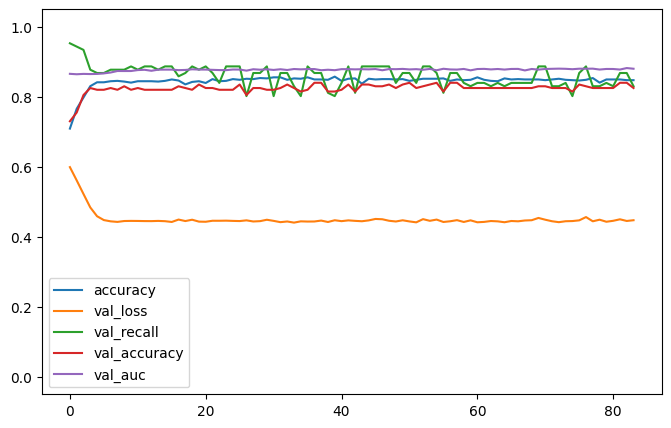

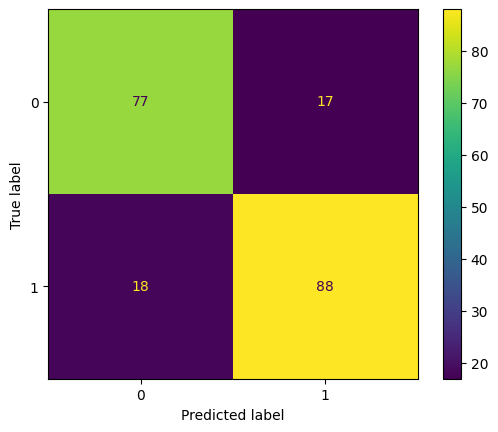

Epoch 65: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['chest_pain_type_4', 'ST_slope_1', 'ST_slope_2', 'sex']
7/7 [==============================] - 0s 552us/s

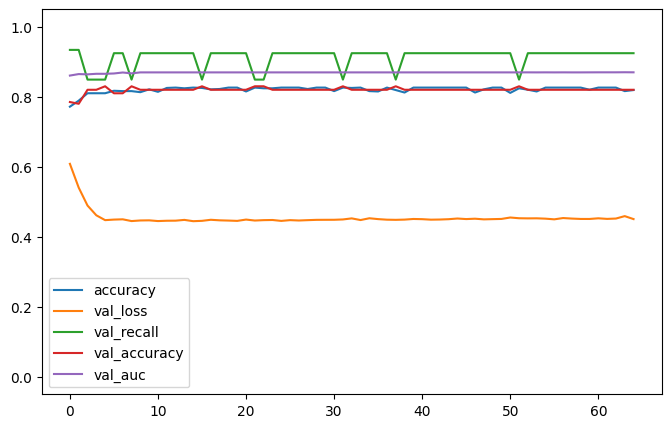

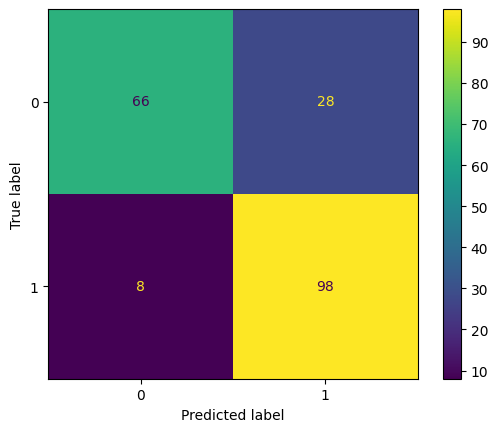

Epoch 131: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['ST_slope_1', 'ST_slope_2', 'sex']
7/7 [==============================] - 0s 580us/step
Accuracy:  0.79


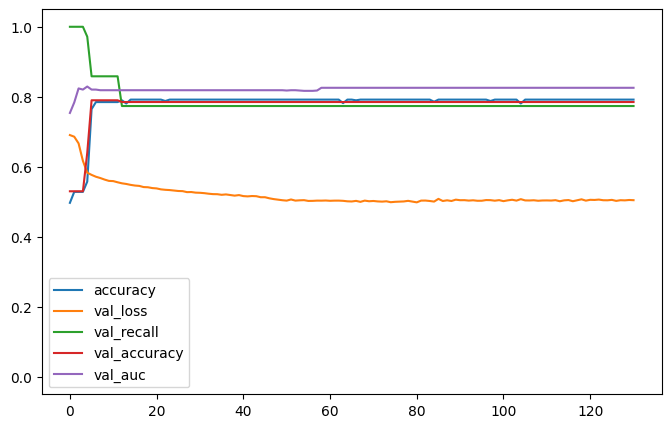

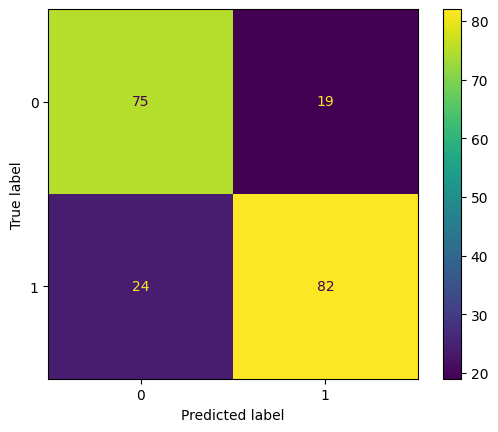

Epoch 111: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['ST_slope_2', 'sex']
7/7 [==============================] - 0s 618us/step
Accuracy:  0.76
Specificity:  

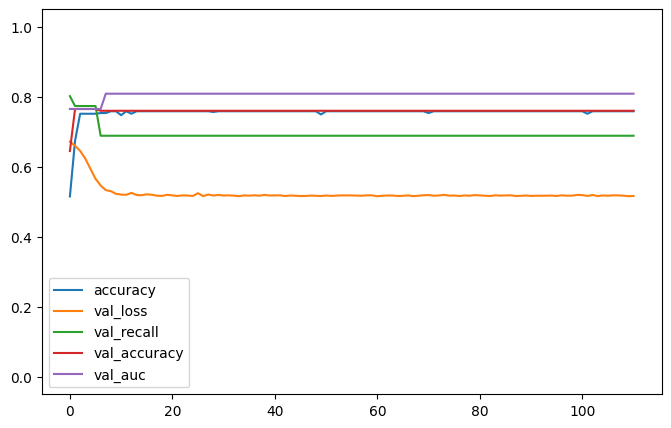

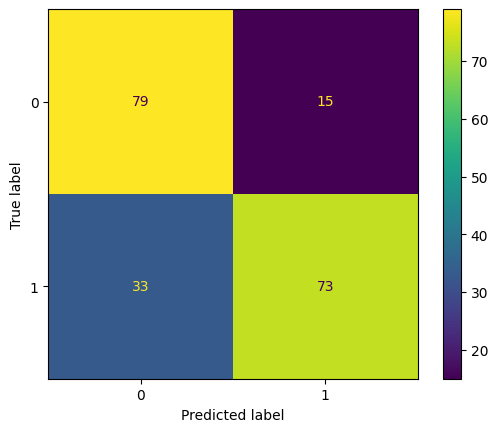

Epoch 143: early stopping
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 16)                256       
                                                                 
 dense_42 (Dense)            (None, 16)                272       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
 dense_44 (Dense)            (None, 1)                 13        
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Included features: ['sex']
7/7 [==============================] - 0s 580us/step
Accuracy:  0.65
Specificity:  0.37
Recall:  

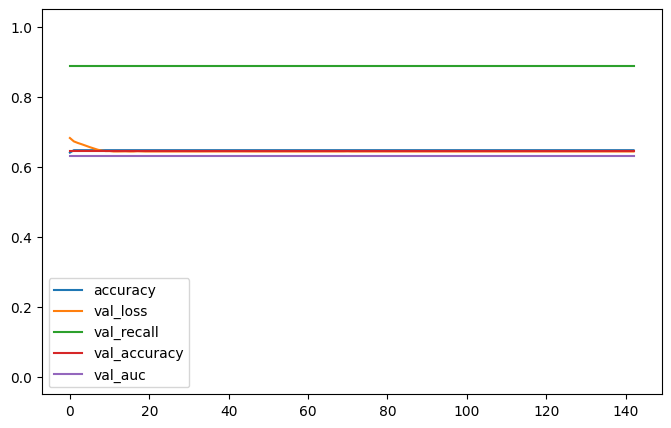

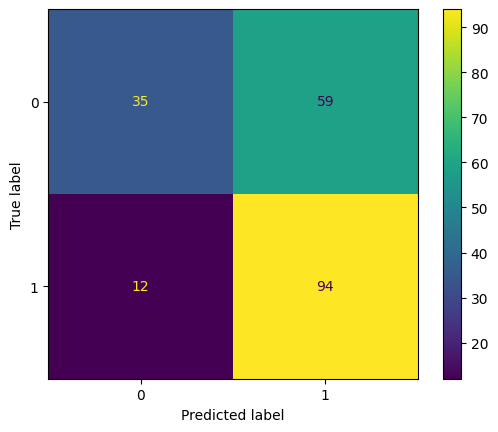

In [94]:
feature_rank = ["ecg_1", "resting_bp_s", "ecg_2",
                    "fasting_blood_sugar", "age", "max_heart_rate",
                    "chest_pain_type_2", "cholesterol", "exercise_angina",
                    "chest_pain_type_3", "oldpeak", "chest_pain_type_4", 
                    "ST_slope_1", "ST_slope_2", "sex"]

removed_features = []
for i in range(X_train.shape[1]-1):
    feature_rank.pop(0)
    model_s = Sequential()
    model_s.add(Dense(16, input_dim=len(feature_rank), activation='relu'))
    model_s.add(Dense(16, activation='relu'))
    model_s.add(Dense(12, activation='relu'))
    model_s.add(Dense(12, activation='relu'))
    model_s.add(Dense(1, activation='sigmoid'))
    history_s = train_model(model_s, X_train.loc[:,feature_rank], y_train, X_test.loc[:,feature_rank], y_test)
    print(model.summary())
    print(f"Included features: {feature_rank}")
    evaluate_model(model_s, history_s, X_test.loc[:,feature_rank], y_test)

## Phase 5: Final Report  

* Please submit a PDF of your final report.
* 10/12 pages at most.
* Should include abstract and conclusion (each 250 words minimum).
* It should contain the important findings in each phase of your project.
* Your final/best model should be evaulated using ROC and AUC
* Your report should NOT include the results of your Phase II.
* Your tables and figures should be numbered and captioned (labelled) appropriately.
* Submit a link to your final Notebook. Optionally, you are welcome to host your project (and report) at Github (i.e., no extra points for hosting). .